In [1]:
# === BLOCK 1: Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

In [2]:
# === BLOCK 2: UTILITY FUNCTIONS ===
def set_xaxis_format(ax, tick_interval):
    tick_interval = tick_interval.lower()
    if tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    elif tick_interval == 'weekly':
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    elif tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

def filter_by_time(df, start_time, end_time):
    return df.loc[start_time:end_time].copy()

def calculate_delta_t(df):
    df['Delta_T'] = df['Return_Temperature'] - df['Inlet_Temperature']
    return df

def aggregate_data(df, freq):
    freq = freq.lower()
    numeric_df = df.select_dtypes(include='number')
    if freq == "hourly":
        return numeric_df.resample('h').sum()
    elif freq == "daily":
        return numeric_df.resample('D').sum()
    else:
        return numeric_df

def load_compressor_trend_data(file_path):
    df = pd.read_excel(file_path)
    df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce')
    df = df.rename(columns={
        '01EM2_TTA - Interval Trend Log': 'Inlet_Temperature',
        '01EM2_TTR - Interval Trend Log': 'Return_Temperature',
        'Flow - Interval Trend Log': 'Flow_Rate',
        'Power - Interval Trend Log': 'Power_KW'
    })
    df['Inlet_Temperature'] = pd.to_numeric(df['Inlet_Temperature'], errors='coerce')
    df['Return_Temperature'] = pd.to_numeric(df['Return_Temperature'], errors='coerce')
    df['Flow_Rate'] = pd.to_numeric(df['Flow_Rate'], errors='coerce')
    df['Power_KW'] = pd.to_numeric(df['Power_KW'], errors='coerce')
    df.dropna(subset=['Time stamp'], inplace=True)
    df.set_index('Time stamp', inplace=True)
    df.sort_index(inplace=True)
    return df

In [3]:
# === BLOCK 3: CONTROLLABLE PARAMETERS ===

FILE_PATH = r"./Productie warmtepomp.xlsx"
TREND_FILE_PATH = r"./Trend EM WP.xlsx"

START_TIME = '2024-11-01 00:00:00'
END_TIME = '2025-11-18 00:00:00'

TICK_INTERVAL = 'monthly'

/tmp/ipykernel_25297/49920738.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce')


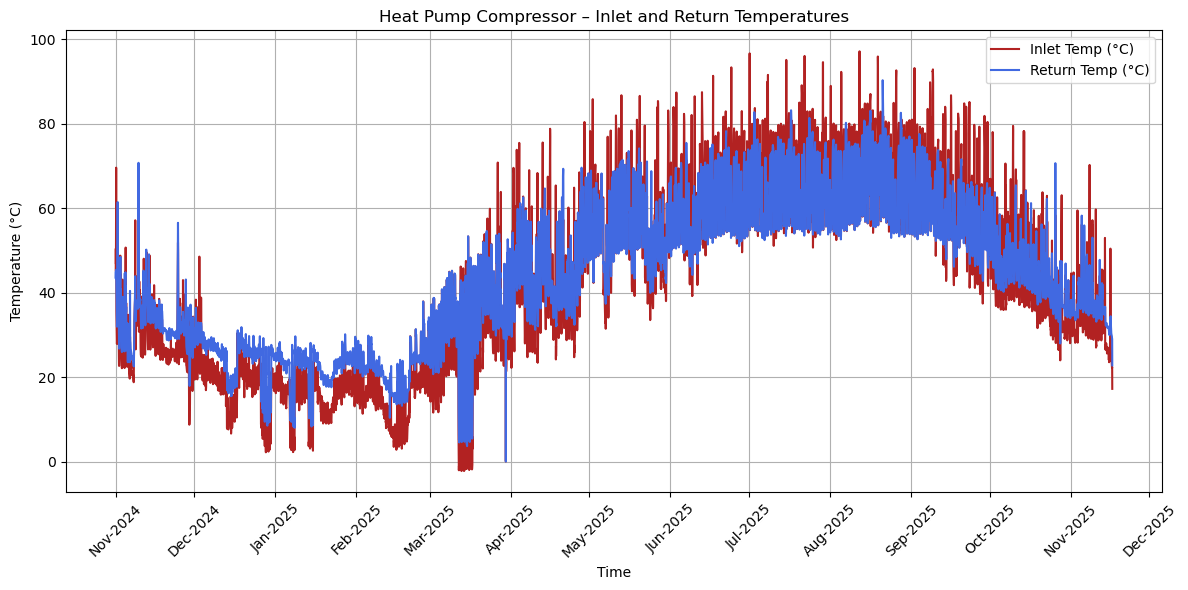

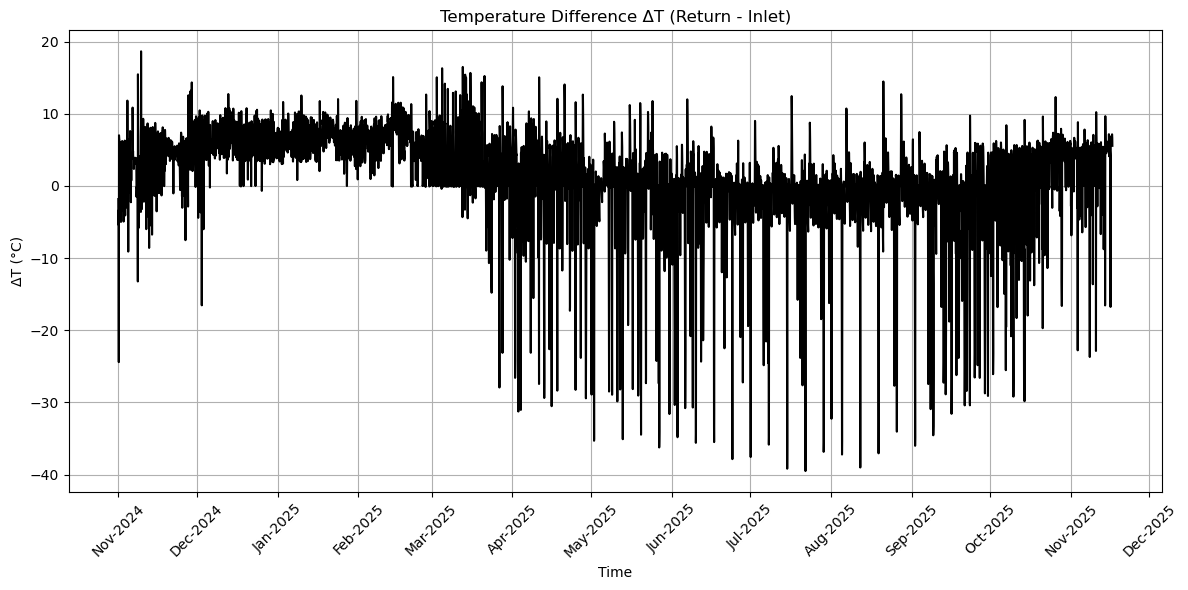

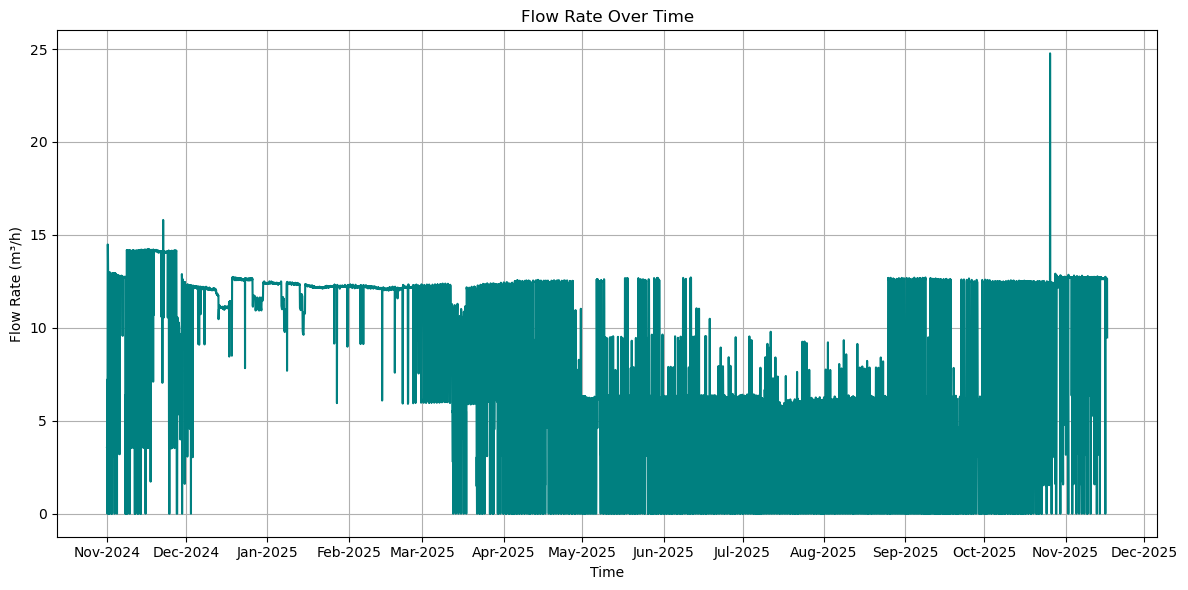

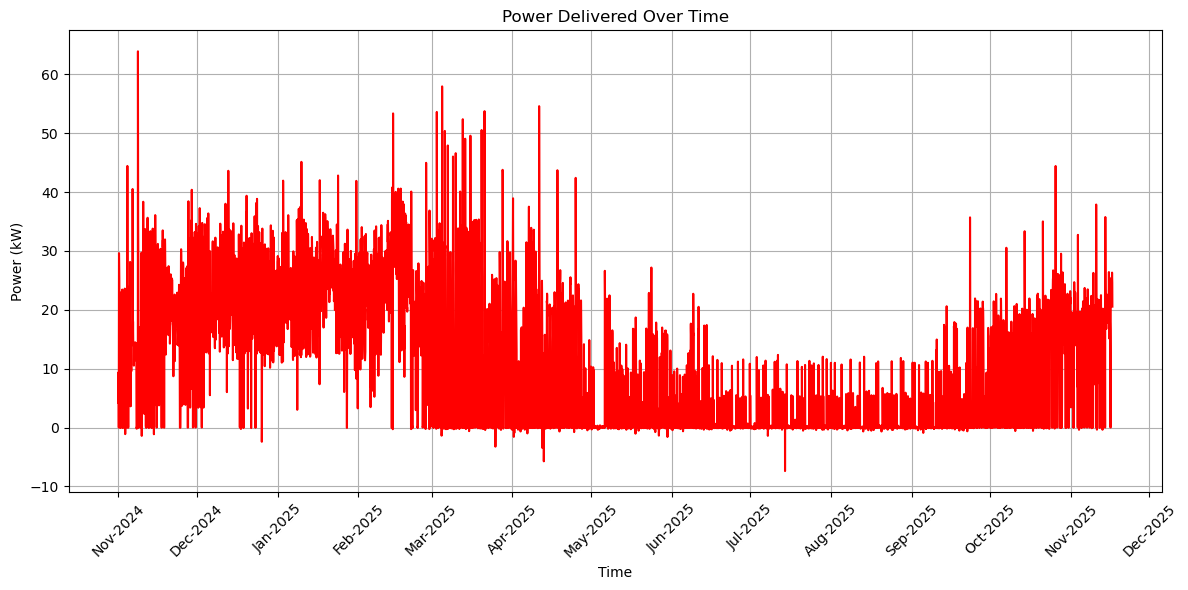

In [4]:
AGGREGATION_FREQ = 'hourly'  # Options: 'raw', 'hourly', 'daily'
# === BLOCK 5: COMPRESSOR-SIDE TREND DATA WITH AGGREGATION ===
def plot_compressor_trends(df, tick_interval='daily'):
    # Plot 1: Inlet and Return Temperatures
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Inlet_Temperature'], color='firebrick', label='Inlet Temp (°C)', linewidth=1.5)
    plt.plot(df.index, df['Return_Temperature'], color='royalblue', label='Return Temp (°C)', linewidth=1.5)
    plt.title('Heat Pump Compressor – Inlet and Return Temperatures')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    set_xaxis_format(plt.gca(), tick_interval)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: ΔT
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Delta_T'], color='black', label='ΔT (Inlet - Return)', linewidth=1.5)
    plt.title('Temperature Difference ΔT (Return - Inlet)')
    plt.xlabel('Time')
    plt.ylabel('ΔT (°C)')
    plt.grid(True)
    set_xaxis_format(plt.gca(), tick_interval)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 3: Flow Rate
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Flow_Rate'], color='teal', label='Flow Rate (m³/h)', linewidth=1.5)
    plt.title('Flow Rate Over Time')
    plt.xlabel('Time')
    plt.ylabel('Flow Rate (m³/h)')
    plt.grid(True)
    set_xaxis_format(plt.gca(), tick_interval)
    plt.tight_layout()
    plt.show()

    # Plot 4: Power
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Power_KW'], color='red', label='Power (kW)', linewidth=1.5)
    plt.title('Power Delivered Over Time')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.grid(True)
    set_xaxis_format(plt.gca(), tick_interval)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === EXECUTION ===
compressor_df = load_compressor_trend_data(TREND_FILE_PATH)
filtered_compressor_df = filter_by_time(compressor_df, START_TIME, END_TIME)
filtered_compressor_df = calculate_delta_t(filtered_compressor_df)
aggregated_df = aggregate_data(filtered_compressor_df, AGGREGATION_FREQ)
plot_compressor_trends(aggregated_df, tick_interval=TICK_INTERVAL)


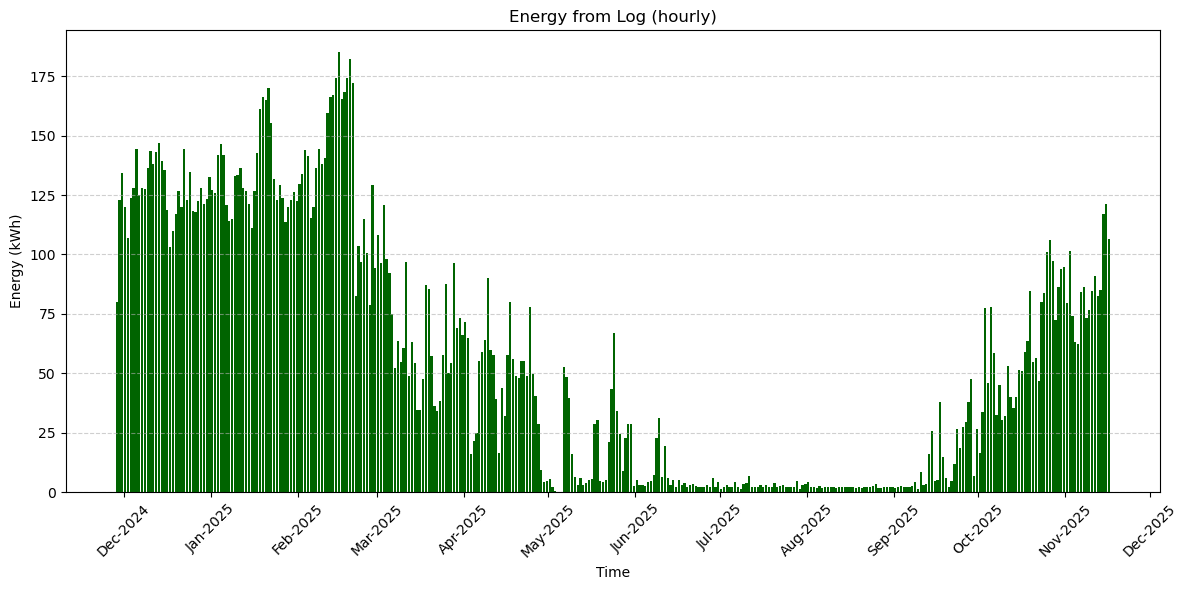

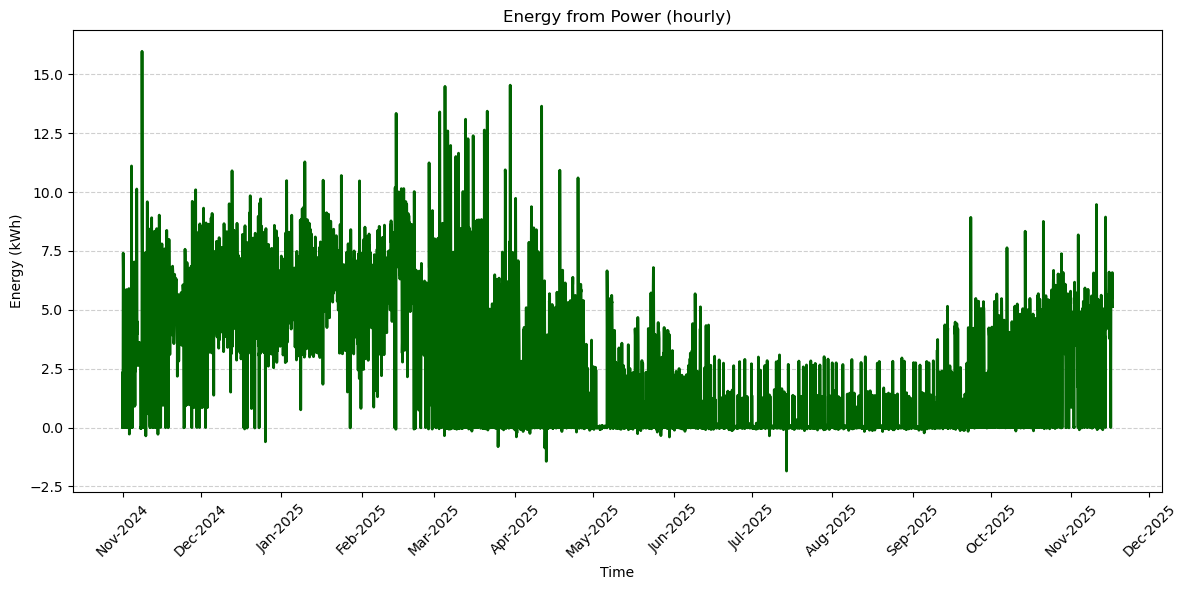

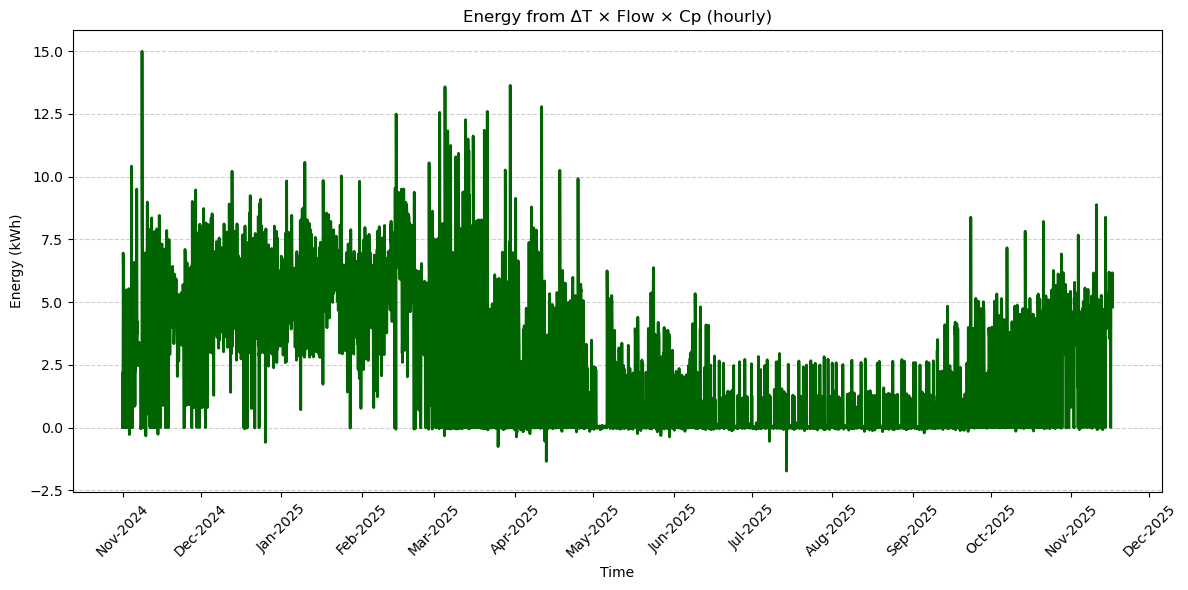

In [5]:
# === BLOCK 6: COMPRESSOR-SIDE ENERGY DELIVERY COMPARISON ===
AGGREGATION_FREQ = 'hourly'  # Options: 'raw', 'hourly', 'daily'
def load_logged_energy(file_path):
    df = pd.read_excel(file_path)
    df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce')
    df = df.rename(columns={'01EM2_Energy Interval Trend Log': 'Logged_Energy_kWh'})
    df.dropna(subset=['Time stamp', 'Logged_Energy_kWh'], inplace=True)
    df.set_index('Time stamp', inplace=True)
    df.sort_index(inplace=True)
    return df

def compute_energy_from_power(df):
    df = df.copy()
    df['Time_Delta_hr'] = df.index.to_series().diff().dt.total_seconds() / 3600
    df['Power_Energy_kWh'] = df['Power_KW'] * df['Time_Delta_hr']
    df['Power_Energy_kWh'] = df['Power_Energy_kWh'].fillna(0)
    return df

def compute_thermal_energy(df):
    df = df.copy()
    cp = 3800  # J/kg·K for 14% glycol-water
    rho = 1035  # kg/m³
    df['Time_Delta_hr'] = df.index.to_series().diff().dt.total_seconds() / 3600  # hours
    df['Thermal_Energy_kWh'] = df['Flow_Rate'] * rho * cp * df['Delta_T'] * df['Time_Delta_hr'] / 3.6e6  # kWh
    df['Thermal_Energy_kWh'] = df['Thermal_Energy_kWh'].fillna(0)
    return df


def plot_energy_series(df, time_col, energy_col, title, color, kind='bar'):
    plt.figure(figsize=(12, 6))
    if kind == 'bar':
        plt.bar(df[time_col], df[energy_col], color=color)
    else:
        plt.plot(df[time_col], df[energy_col], color=color, linewidth=2)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy (kWh)')
    set_xaxis_format(plt.gca(), TICK_INTERVAL)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# === LOAD, COMPUTE, AND AGGREGATE ===

# 1. Logged energy
logged_df = load_logged_energy(FILE_PATH)
logged_df = filter_by_time(logged_df, START_TIME, END_TIME)
logged_plot_df = aggregate_data(logged_df, AGGREGATION_FREQ).reset_index()

# 2. Power-based energy
power_df = compute_energy_from_power(filtered_compressor_df)
power_plot_df = aggregate_data(power_df, AGGREGATION_FREQ).reset_index()

# 3. ΔT × Flow × Cp
thermal_df = compute_thermal_energy(filtered_compressor_df)
thermal_plot_df = aggregate_data(thermal_df, AGGREGATION_FREQ).reset_index()

# === PLOTS ===
plot_energy_series(logged_plot_df, 'Time stamp', 'Logged_Energy_kWh',
                   f'Energy from Log ({AGGREGATION_FREQ})', 'darkgreen', kind='bar')

plot_energy_series(power_plot_df, 'Time stamp', 'Power_Energy_kWh',
                   f'Energy from Power ({AGGREGATION_FREQ})', 'darkgreen', kind='bar' if AGGREGATION_FREQ == 'daily' else 'line')

plot_energy_series(thermal_plot_df, 'Time stamp', 'Thermal_Energy_kWh',
                   f'Energy from ΔT × Flow × Cp ({AGGREGATION_FREQ})', 'darkgreen', kind='bar' if AGGREGATION_FREQ == 'daily' else 'line')


In [6]:
# === BLOCK 7: COMPRESSOR-SIDE DAILY ENERGY COMPARISON TABLE ===

# Rename columns to unify format
logged_plot_df = logged_plot_df.rename(columns={'Time stamp': 'Time', 'Logged_Energy_kWh': 'Logged_Energy'})
power_plot_df = power_plot_df.rename(columns={'Time stamp': 'Time', 'Power_Energy_kWh': 'Power_Energy'})
thermal_plot_df = thermal_plot_df.rename(columns={'Time stamp': 'Time', 'Thermal_Energy_kWh': 'Thermal_Energy'})

# Merge all three DataFrames on 'Time'
energy_comparison_df = pd.merge(logged_plot_df[['Time', 'Logged_Energy']],
                                power_plot_df[['Time', 'Power_Energy']],
                                on='Time', how='outer')

energy_comparison_df = pd.merge(energy_comparison_df,
                                thermal_plot_df[['Time', 'Thermal_Energy']],
                                on='Time', how='outer')

# Sort by time and fill missing with 0
energy_comparison_df.sort_values('Time', inplace=True)
energy_comparison_df.fillna(0, inplace=True)

# Round values for cleaner display
energy_comparison_df[['Logged_Energy', 'Power_Energy', 'Thermal_Energy']] = energy_comparison_df[
    ['Logged_Energy', 'Power_Energy', 'Thermal_Energy']].round(2)

# Display as a table
display(energy_comparison_df)

,Time,Logged_Energy,Power_Energy,Thermal_Energy
8473,2024-11-01 00:00:00,0.0,0.00,0.00
8474,2024-11-01 01:00:00,0.0,1.08,1.01
8475,2024-11-01 02:00:00,0.0,2.35,2.21
8476,2024-11-01 03:00:00,0.0,0.00,0.00
8477,2024-11-01 04:00:00,0.0,0.00,0.00
...,...,...,...,...
9136,2025-11-16 16:00:00,0.0,6.38,5.98
9137,2025-11-16 17:00:00,0.0,6.58,6.17
9138,2025-11-16 18:00:00,0.0,6.35,5.95
9139,2025-11-16 19:00:00,0.0,6.15,5.77


,Period,Logged Energy (kWh),Power-based Energy (kWh),Power Error (%),Thermal Energy (kWh),Thermal Error (%)
0,Entire Period,20285.00,22812.81,12.46,21593.09,6.45
1,Start → Jan 1,4286.53,6860.76,60.05,6430.55,50.02
2,Jan 1 → End,15998.47,15952.06,-0.29,15162.54,-5.23


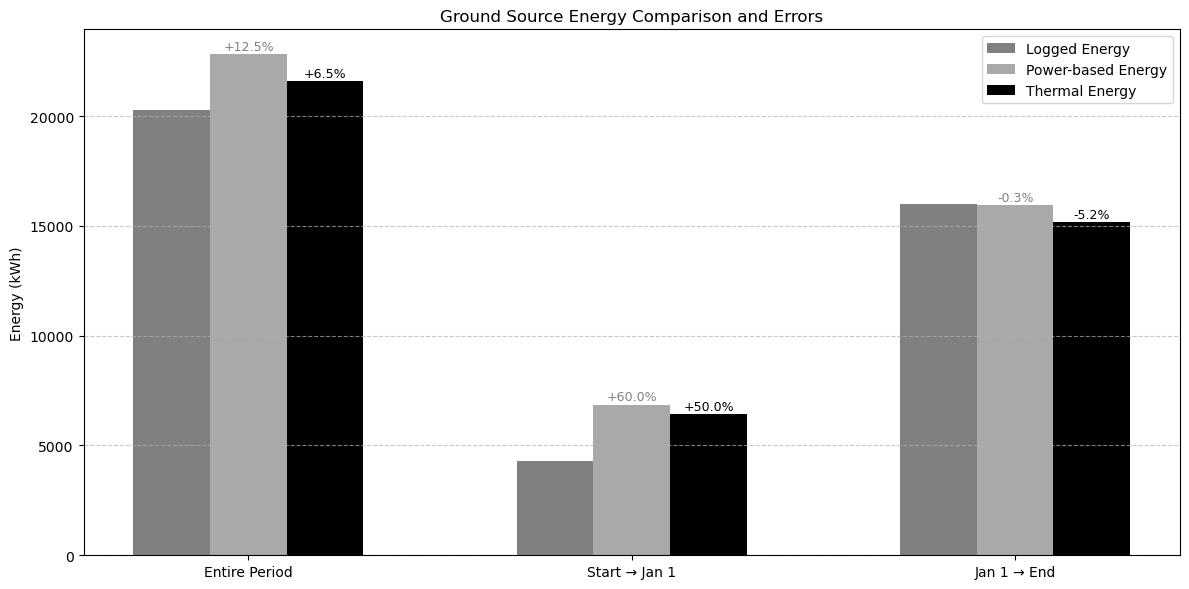

In [7]:
# === BLOCK 7: COMPRESSOR-SIDE ENERGY SUMMARY REPORT ===

# Define periods clearly
periods = {
    'Entire Period': (START_TIME, END_TIME),
    'Start → Jan 1': (START_TIME, '2025-01-01 00:00:00'),
    'Jan 1 → End': ('2025-01-01 00:00:00', END_TIME)
}

# Function to compute totals and errors
def compute_period_summary(logged_df, power_df, thermal_df, start, end):
    mask_logged = (logged_df['Time'] >= pd.to_datetime(start)) & (logged_df['Time'] < pd.to_datetime(end))
    mask_power = (power_df['Time'] >= pd.to_datetime(start)) & (power_df['Time'] < pd.to_datetime(end))
    mask_thermal = (thermal_df['Time'] >= pd.to_datetime(start)) & (thermal_df['Time'] < pd.to_datetime(end))

    total_logged = logged_df.loc[mask_logged, 'Logged_Energy'].sum()
    total_power = power_df.loc[mask_power, 'Power_Energy'].sum()
    total_thermal = thermal_df.loc[mask_thermal, 'Thermal_Energy'].sum()

    power_err = (total_power - total_logged) / total_logged * 100 if total_logged else 0
    thermal_err = (total_thermal - total_logged) / total_logged * 100 if total_logged else 0

    return {
        'Logged Energy (kWh)': total_logged,
        'Power-based Energy (kWh)': total_power,
        'Thermal Energy (kWh)': total_thermal,
        'Power Error (%)': power_err,
        'Thermal Error (%)': thermal_err
    }

# Generate summary data
summary_list = []
for period_name, (start, end) in periods.items():
    summary = compute_period_summary(
        logged_plot_df, power_plot_df, thermal_plot_df, start, end)
    summary['Period'] = period_name
    summary_list.append(summary)

# Convert summaries into DataFrame
summary_df = pd.DataFrame(summary_list)[
    ['Period', 'Logged Energy (kWh)', 'Power-based Energy (kWh)', 'Power Error (%)',
     'Thermal Energy (kWh)', 'Thermal Error (%)']
]

# Round values for readability
summary_df = summary_df.round(2)

# Display as table
display(summary_df)

# Plotting the summary comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and positions
bar_width = 0.2
x = range(len(summary_df))

# Bars for energies
ax.bar([i - bar_width for i in x], summary_df['Logged Energy (kWh)'],
       width=bar_width, color='gray', label='Logged Energy')
ax.bar(x, summary_df['Power-based Energy (kWh)'],
       width=bar_width, color='darkgray', label='Power-based Energy')
ax.bar([i + bar_width for i in x], summary_df['Thermal Energy (kWh)'],
       width=bar_width, color='black', label='Thermal Energy')

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Period'])
ax.set_ylabel('Energy (kWh)')
ax.set_title('Ground Source Energy Comparison and Errors')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate errors above bars
for idx, row in summary_df.iterrows():
    ax.text(idx, row['Power-based Energy (kWh)'] + max(summary_df['Logged Energy (kWh)']) * 0.01,
            f"{row['Power Error (%)']:+.1f}%", ha='center', color='gray', fontsize=9)
    ax.text(idx + bar_width, row['Thermal Energy (kWh)'] + max(summary_df['Logged Energy (kWh)']) * 0.01,
            f"{row['Thermal Error (%)']:+.1f}%", ha='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()


In [31]:
import os
import dill as pickle
import types
import io

os.makedirs("outputs", exist_ok=True)

global_vars = dict(globals())
saved_vars = {}

for name, val in global_vars.items():
    if (
        name.startswith("_")
        or isinstance(val, (types.ModuleType, types.FunctionType, type))
        or isinstance(val, io.IOBase)  # exclude open file handles
        or name in {"saved_vars", "global_vars", "name", "val", "f", "open"}
    ):
        continue
    try:
        pickle.dumps(val)
        saved_vars[name] = val
    except Exception:
        print(f"⚠️ Skipping variable '{name}' — not dill-serializable.")

real_saved_vars = {}
for name in ['compressor_df', 'filtered_compressor_df', 'filtered_compressor_df', 'aggregated_df']:
    real_saved_vars[name] = saved_vars[name]
saved_vars = real_saved_vars


print('saving:', ', '.join(list(saved_vars.keys())))
# Save to file
file_path = "outputs/EnergyMeter_outputs.pkl"
with open(file_path, "wb") as f_out:
    pickle.dump(saved_vars, f_out)

print(f"✅ Safely saved {len(saved_vars)} variables to {file_path}")


⚠️ Skipping variable 'get_ipython' — not dill-serializable.
⚠️ Skipping variable 'exit' — not dill-serializable.
⚠️ Skipping variable 'quit' — not dill-serializable.
saving: compressor_df, filtered_compressor_df, aggregated_df
✅ Safely saved 3 variables to outputs/EnergyMeter_outputs.pkl


In [9]:
file_path = "outputs/EnergyMeter_outputs.pkl"
with open(file_path, "rb") as f:
    a = pickle.load(f)
print(a)

{'In': ['', '# === BLOCK 1: Libraries ===\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nfrom IPython.display import display', '# === BLOCK 2: UTILITY FUNCTIONS ===\ndef set_xaxis_format(ax, tick_interval):\n    tick_interval = tick_interval.lower()\n    if tick_interval == \'hourly\':\n        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))\n        ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%H:%M\\n%d-%b\'))\n    elif tick_interval == \'daily\':\n        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))\n        ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%d-%b\'))\n    elif tick_interval == \'weekly\':\n        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))\n        ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%d-%b\'))\n    elif tick_interval == \'monthly\':\n        ax.xaxis.set_major_locator(mdates.MonthLocator())\n        ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%b-%Y\

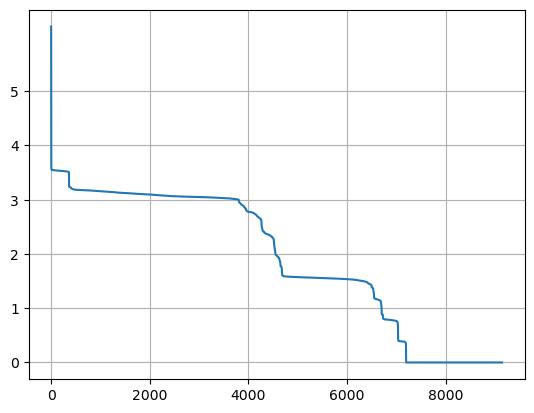

In [10]:
import numpy as np
flow_rate = aggregated_df['Flow_Rate'].to_numpy()/4
flow_rate.sort()
plt.plot(flow_rate[::-1])
plt.yticks(np.arange(0, 6, 1))
plt.grid()
plt.show()